In [ ]:
%pip install ccxt==4.4.71 pandas==2.2.2 tqdm==4.67.1 matplotlib==3.10.0 seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.14
    Uninstalling aiohttp-3.11.14:
      Successfully uninstalled aiohttp-3.11.14


In [ ]:
import ccxt
import pandas as pd
from datetime import datetime, timezone, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# @title Введите id биржи https://docs.ccxt.com/#/?id=exchanges
exchange_id = "binanceus" # @param {"type":"string"}
exchange = getattr(ccxt, exchange_id)()

In [ ]:
# @title Введите https proxy для получения данных с Binance или Bybit
https_proxy = "" # @param {"type":"string","placeholder":"Leave blank if you do not want to use a proxy"}
exchange.httpsProxy = https_proxy

In [ ]:
# @title Выберете дату до которой анализировать данные
end_day = "2025-03-30" # @param {"type":"date"}

In [ ]:
def get_ohlcv(limit=1000, timeframe='1d', exchange=exchange, end_day='30/03/2025'):
    end_day = datetime.strptime(end_day, '%Y-%m-%d')
    start_day = end_day - timedelta(days=limit)
    since_timestamp = int(start_day.timestamp() * 1000)
    data = pd.DataFrame()
    try:
        exchange.load_markets() # Markets should be loaded prior to accessing this property
        print(f'Downloading data from {exchange.id}')
        with tqdm(total=len(exchange.markets)) as pbar: # progress bar
            for symbol in exchange.markets:
                if symbol.endswith('/USDT') and exchange.markets[symbol]['active']:
                    symbol_data = pd.DataFrame(exchange.fetch_ohlcv(symbol, timeframe, since=since_timestamp, limit=limit),
                                              columns=['Date', 'O', 'H', 'L', symbol, 'V'])[['Date', symbol]]
                    symbol_data.set_index('Date', inplace=True)
                    symbol_data.index = pd.to_datetime(symbol_data.index, unit='ms', utc=True)
                    # Filter coins that trade less than limit days
                    if symbol_data.shape[0] >= limit-1: #  to avoid a situation where there are no transactions yet on the new day
                        data = pd.concat([data, symbol_data], axis=1)
                pbar.update(1)
        if data.shape[1] < 2 or data.shape[0] == 0:
            print('No valid data for analysis')
        return data.iloc[:-2] # skip current day, because there are haven't close of the day
    except Exception as e:
        print('Trouble with downloading data\n')
        print(e)

In [ ]:
df = get_ohlcv(limit=1000, timeframe='1d', exchange=exchange, end_day=end_day)

100%|██████████| 572/572 [00:21<00:00, 26.44it/s]


<Axes: >

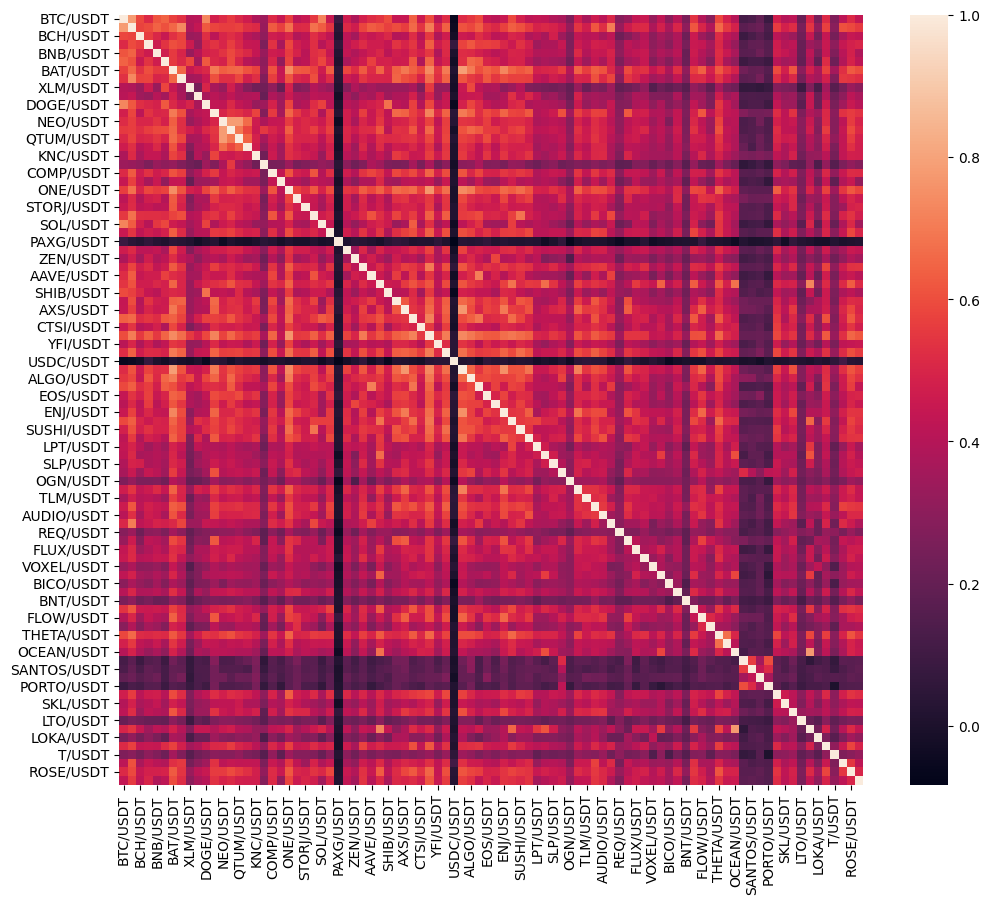

In [ ]:
corr_data = df.diff().dropna().corr(method='pearson')
plt.figure(figsize=(12,10))
sns.heatmap(corr_data, annot=False)

In [ ]:
corr_data = corr_data[corr_data <= 0.99]
corr_data = corr_data.unstack().dropna().drop_duplicates().reset_index()
corr_data.sort_values(by=[0], ascending=False, inplace=True)

In [ ]:
corr_data

,level_0,level_1,0
553,BAT/USDT,MANA/USDT,0.788333
0,BTC/USDT,ETH/USDT,0.782745
1003,NEO/USDT,QTUM/USDT,0.782422
1002,NEO/USDT,VET/USDT,0.781304
3893,OCEAN/USDT,FET/USDT,0.775258
...,...,...,...
874,DOGE/USDT,USDC/USDT,-0.056248
2359,SHIB/USDT,USDC/USDT,-0.058730
39,BTC/USDT,USDC/USDT,-0.060098
2016,PAXG/USDT,OGN/USDT,-0.069193
